# Calibrating a GraphSAGE node classification model

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/calibration/calibration-node-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/calibration/calibration-node-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

This notebook demonstrates probability calibration for multi-class node attribute inference. The classifier used is GraphSAGE and the dataset is the citation network Pubmed-Diabetes. Our task is to predict the subject of a paper (the nodes in the graph) that is one of 3 classes. The data are the network structure and for each paper a 500-dimensional TF/IDF word vector.

The notebook demonstrates the use of StellarGraph's `TemperatureCalibration` and `IsotonicCalibration` classes as well as supporting methods for calculating the Expected Calibration Error (ECE) and plotting reliability diagrams [2].

Since the focus of this notebook is to demonstrate the calibration of StellarGraph's graph neural network models for classification, we do not go into detail on the training and evaluation of said models. We suggest the reader consider the following notebook for more details on how to train and evaluate a GraphSAGE model for node attribute inference,

[Stellargraph example: GraphSAGE on the CORA citation network](../node-classification/graphsage-node-classification.ipynb)

**References**
1. Inductive Representation Learning on Large Graphs. W.L. Hamilton, R. Ying, and J. Leskovec arXiv:1706.02216 
[cs.SI], 2017. ([link](http://snap.stanford.edu/graphsage/))

2. On Calibration of Modern Neural Networks. C. Guo, G. Pleiss, Y. Sun, and K. Q. Weinberger. 
ICML 2017. ([link](https://geoffpleiss.com/nn_calibration))

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.3.0b

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.3.0b")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.3.0b, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import networkx as nx
import pandas as pd
import os
import itertools

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
import tensorflow as tf

import numpy as np

from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegressionCV
from sklearn.isotonic import IsotonicRegression

from sklearn.metrics import accuracy_score

from stellargraph.calibration import TemperatureCalibration, IsotonicCalibration
from stellargraph.calibration import plot_reliability_diagram, expected_calibration_error

from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

In [4]:
# Given a GraphSAGE model, a node generator, and the number of predictions per point
# this method makes n_predictions number of predictions and then returns the average
# prediction for each query node.
def predict(model, node_generator, n_predictions=1):
    preds_ar = np.array([model.predict(node_generator) for _ in range(n_predictions)])
    print(preds_ar.shape)
    return np.mean(preds_ar, axis=0)

## Some global parameters

In [5]:
epochs = 20  # number of training epochs for GraphSAGE model
n_predictions = 5  # number of predictions per query node

## Loading the Pubmed-Diabetes network data

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [6]:
dataset = datasets.PubMedDiabetes()
display(HTML(dataset.description))
G, subjects = dataset.load()

In [7]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 19717, Edges: 44338

 Node types:
  paper: [19717]
    Features: float32 vector, length 500
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [44338]


### Splitting the data

For machine learning, we want to take a subset of the nodes for training, and use the rest for testing. We'll use scikit-learn again to do this.

In [8]:
train_subjects, test_subjects = model_selection.train_test_split(
    subjects, train_size=0.75, test_size=None, stratify=subjects
)
train_subjects, val_subjects = model_selection.train_test_split(
    train_subjects, train_size=0.75, test_size=None, stratify=train_subjects
)

In [9]:
len(train_subjects), len(val_subjects), len(test_subjects)

(11090, 3697, 4930)

Note using stratified sampling gives the following counts:

In [10]:
from collections import Counter

Counter(train_subjects), Counter(val_subjects), Counter(test_subjects)

(Counter({3: 4353, 2: 4429, 1: 2308}),
 Counter({2: 1477, 3: 1451, 1: 769}),
 Counter({3: 1935, 2: 1969, 1: 1026}))

The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training. To do this conversion ...

In [11]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [12]:
train_targets

array([[0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1]])

## Creating the GraphSAGE model in Keras

To feed data from the graph to the Keras model, we need a node generator. The node generators are specialized to the model and the learning task. Since we are predicting node attributes using a GraphSAGE model, we will opt to use `GraphSAGENodeGenerator` here.

We need two other parameters, i) the `batch_size` to use for training and ii) the number of nodes to sample at each level of the model. Here we choose a two-level model with 10 nodes sampled in the first layer, and 5 in the second.

In [13]:
batch_size = 50
num_samples = [10, 5]

A `GraphSAGENodeGenerator` object is required to send the node features in sampled subgraphs to Keras.

In [14]:
generator = GraphSAGENodeGenerator(G, batch_size, num_samples)

For training, we map only the training nodes returned from our splitter and the target values.

In [15]:
train_gen = generator.flow(train_subjects.index, train_targets)

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use 32-dimensional hidden node features at each layer.
 * The `bias` and `dropout` are internal parameters of the model. 

In [16]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
)

Now we create a model to predict the 3 categories using Keras softmax layers.

In [17]:
x_inp, x_out = graphsage_model.in_out_tensors()
logits = layers.Dense(units=train_targets.shape[1], activation="linear")(x_out)

prediction = layers.Activation(activation="softmax")(logits)

In [18]:
prediction.shape

TensorShape([None, 3])

### Training the model

Now let's create the actual Keras model with the graph inputs `x_inp` provided by the `graph_model` and outputs being the predictions from the softmax layer.

In [19]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=[metrics.categorical_accuracy],
)

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the test set (we need to create another generator over the test data for this).

In [20]:
val_gen = generator.flow(val_subjects.index, val_targets)
test_gen = generator.flow(test_subjects.index, test_targets)

In [21]:
history = model.fit(
    train_gen, epochs=epochs, validation_data=val_gen, verbose=0, shuffle=True,
)

  ['...']
  ['...']


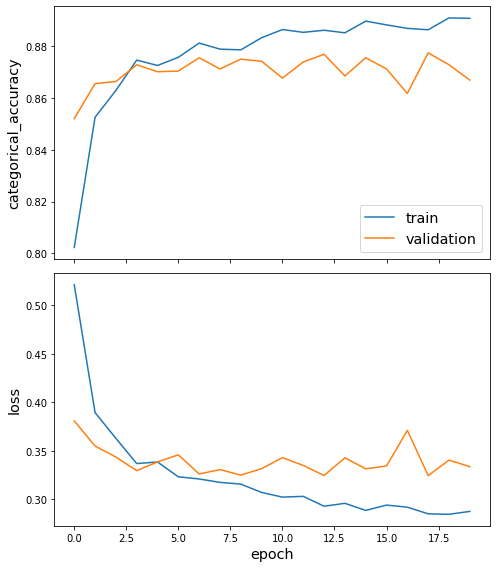

In [22]:
sg.utils.plot_history(history)

Now that we have trained the model, we can evaluate on the test set.

In [23]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print(f"\t{name}: {val:0.4f}")

  ['...']
99/99 [==============================] - 3s 29ms/step - loss: 0.3183 - categorical_accuracy: 0.8815

Test Set Metrics:
	loss: 0.3183
	categorical_accuracy: 0.8815


## Calibration Curves



We want to determine if the classifier produces well-calibrated probabilities. Calibration curves, also known as reliability diagrams, are a visual method for this task. See reference [2] for more details.

Diagnosis of model miscalibration should be performed on a held-out dataset that was not used for training. We are going to utilise our test set for this purpose. Equivalently, we can use our validation dataset.

In [24]:
test_nodes = test_subjects.index
test_node_generator = generator.flow(test_nodes)

In [25]:
# test_predictions holds the model's probabilistic output predictions
test_predictions = predict(model, test_node_generator, n_predictions=n_predictions)

(5, 4930, 3)


In [26]:
# Convert the list of dictionaries to a dataframe so that it is easier to work with the data
test_pred_results = pd.DataFrame(
    test_predictions, columns=target_encoding.classes_, index=test_subjects.index
)
test_pred_results.head()

,1,2,3
pid,,,
15531498,0.000916,0.171522,0.827562
8071960,0.000386,0.984824,0.014790
1769441,0.774302,0.192302,0.033396
9230640,0.000404,0.020510,0.979086
18375412,0.000313,0.973282,0.026405


We are going to draw one calibration curve for each column in `test_pred_results`.

In [27]:
test_pred = test_pred_results.values
test_pred.shape

(4930, 3)

In [28]:
calibration_data = []
for i in range(test_pred.shape[1]):  # iterate over classes
    calibration_data.append(
        calibration_curve(
            y_prob=test_pred[:, i], y_true=test_targets[:, i], n_bins=10, normalize=True
        )
    )

In [29]:
calibration_data[0], type(calibration_data[0])

((array([0.01083936, 0.21472393, 0.33333333, 0.36923077, 0.51470588,
         0.56716418, 0.82      , 0.81395349, 0.7755102 , 0.96714286]),
  array([0.00766683, 0.14377305, 0.24319112, 0.34574198, 0.4578391 ,
         0.54677253, 0.64486979, 0.7513665 , 0.85948025, 0.9750644 ])),
 tuple)

Also calculate Expected Calibration Error (ECE) for each class. See equation (3) within reference [2] for the definition of ECE.

In [30]:
ece = []
for i in range(test_pred.shape[1]):
    fraction_of_positives, mean_predicted_value = calibration_data[i]
    ece.append(
        expected_calibration_error(
            prediction_probabilities=test_pred[:, i],
            accuracy=fraction_of_positives,
            confidence=mean_predicted_value,
        )
    )

In [31]:
ece

[0.012706240610276162, 0.02207298490740294, 0.018337584007971253]

Draw the reliability diagrams for each class.

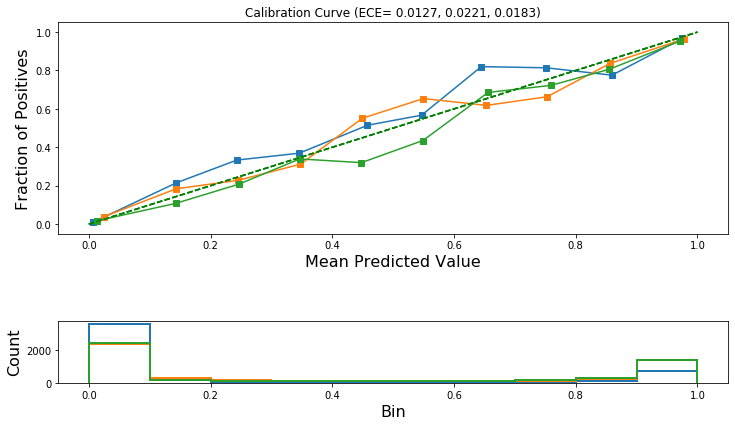

In [32]:
plot_reliability_diagram(calibration_data, test_pred, ece=ece)

## Temperature scaling calibration

Temperature scaling is an extension of [Platt scaling](https://en.wikipedia.org/wiki/Platt_scaling) for calibrating multi-class classification models. It was proposed in reference [2]. 

Temperature scaling uses a single parameter called the `temperature` to scale a classifier's non-probabilistic outputs (logits) before the application of the softmax operator that generates the model's probabilistic outputs.

$\hat{q}_i = \max\limits_{k} \sigma_{SM}(\mathbf{z}_i/T)^{(k)}$ 

where $\hat{q}_i$ is the calibrated probability for the predicted class of the i-th node; $\mathbf{z}_i$ is the vector of logits; $T$ is the temperature; $k$ is the k-th class; and, $\sigma_{SM}$ is the softmax function.

In [33]:
# this model gives the model's non-probabilistic outputs required for Temperature scaling.
score_model = Model(inputs=x_inp, outputs=logits)

Prepare the training data such that inputs are the model output logits and corresponding true class labels are one-hot encoded.

We are going to train the calibration model on the validation dataset.

In [34]:
val_nodes = val_subjects.index
val_node_generator = generator.flow(val_nodes)

In [35]:
test_score_predictions = predict(
    score_model, test_node_generator, n_predictions=n_predictions
)
val_score_predictions = predict(
    score_model, val_node_generator, n_predictions=n_predictions
)

(5, 4930, 3)
(5, 3697, 3)


In [36]:
test_score_predictions.shape, val_score_predictions.shape

((4930, 3), (3697, 3))

In [37]:
x_cal_train_all = val_score_predictions
y_cal_train_all = val_targets

We are going to split the above data to a training and validation set. We are going to use the former for training the calibration model and the latter for early stopping.

In [38]:
x_cal_train, x_cal_val, y_cal_train, y_cal_val = model_selection.train_test_split(
    x_cal_train_all, y_cal_train_all
)

In [39]:
x_cal_train.shape, x_cal_val.shape, y_cal_train.shape, y_cal_val.shape

((2772, 3), (925, 3), (2772, 3), (925, 3))

Create the calibration object.

In [40]:
calibration_model_temperature = TemperatureCalibration(epochs=1000)
calibration_model_temperature

Now call the `fit` method to train the calibration model.

In [41]:
calibration_model_temperature.fit(
    x_train=x_cal_train, y_train=y_cal_train, x_val=x_cal_val, y_val=y_cal_val
)

Using Early Stopping based on performance evaluated on given validation set.


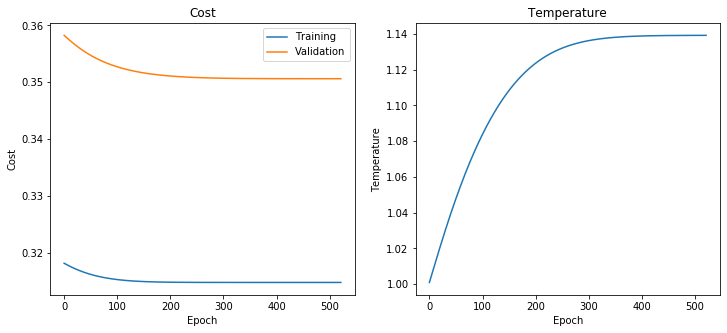

In [42]:
calibration_model_temperature.plot_training_history()

Now we can take the GraphSAGE logits, scale them by `temperature` and then apply the `softmax` to obtain the calibrated probabilities for each class.

**Note** that scaling the logits by `temperature` does not change the predictions so the model's accuracy will not change and there is no need to recalculate them.

In [43]:
test_predictions_calibrated_temperature = calibration_model_temperature.predict(
    x=test_score_predictions
)
test_predictions_calibrated_temperature.shape

(4930, 3)

Now plot the calibration curves and calculate the ECE for each class. We should expect the ECE to be lower after calibration. If not, then a different calibration method should be considered, e.g., Isotonic Regression as described later in this notebook.

In [44]:
calibration_data_after_temperature_scaling = []
for i in range(test_predictions_calibrated_temperature.shape[1]):  # iterate over classes
    calibration_data_after_temperature_scaling.append(
        calibration_curve(
            y_prob=test_predictions_calibrated_temperature[:, i],
            y_true=test_targets[:, i],
            n_bins=10,
            normalize=True,
        )
    )

In [45]:
ece_after_scaling_temperature = []
for i in range(test_predictions_calibrated_temperature.shape[1]):
    (
        fraction_of_positives,
        mean_predicted_value,
    ) = calibration_data_after_temperature_scaling[i]
    ece_after_scaling_temperature.append(
        expected_calibration_error(
            prediction_probabilities=test_predictions_calibrated_temperature[:, i],
            accuracy=fraction_of_positives,
            confidence=mean_predicted_value,
        )
    )

In [46]:
ece_after_scaling_temperature

[0.007640713481013586, 0.008760529204888555, 0.011521251903406684]

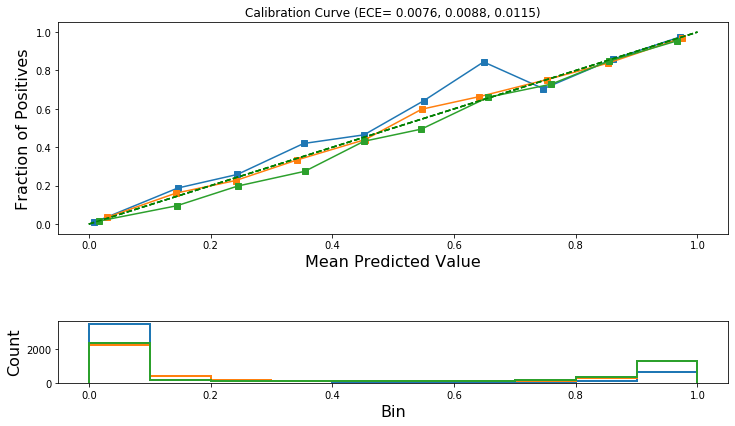

In [47]:
plot_reliability_diagram(
    calibration_data_after_temperature_scaling,
    test_predictions_calibrated_temperature,
    ece=ece_after_scaling_temperature,
)

## Isotonic Regression

We extend [Isotonic calibration](https://scikit-learn.org/stable/modules/generated/sklearn.isotonic.IsotonicRegression.html#sklearn.isotonic.IsotonicRegression) to the multi-class case by calibrating OVR models, one for each class. 

At test time, we calibrate the predictions for each class and then normalize the vector to unit norm so that the output of the calibration is a probability distribution.

**Note** that the input to the Isotonic Calibration model is the classifier's probabilistic outputs as compared to Temperature scaling where the input was the logits. 

In [48]:
test_pred.shape  # Holds the probabilistic predictions for each query node

(4930, 3)

In [49]:
# The probabilistic predictions for the validation set
val_predictions = predict(model, val_node_generator, n_predictions=n_predictions)
val_predictions.shape

(5, 3697, 3)


(3697, 3)

Create the calibration object of type `IsotonicCalibration`.

In [50]:
isotonic_calib = IsotonicCalibration()

Now call the `fit` method to train the calibration model.

In [51]:
isotonic_calib.fit(x_train=val_predictions, y_train=val_targets)

In [52]:
test_pred_calibrated_isotonic = isotonic_calib.predict(test_pred)
test_pred_calibrated_isotonic.shape

(4930, 3)

Now plot the calibration curves and calculate the ECE for each class. We should expect the ECE to be lower after calibration. If not, then a different calibration method should be considered, e.g., Temperature Scaling as described earlier in this notebook.

In [53]:
calibration_data_after_isotonic_scaling = []
for i in range(test_pred_calibrated_isotonic.shape[1]):  # iterate over classes
    calibration_data_after_isotonic_scaling.append(
        calibration_curve(
            y_prob=test_pred_calibrated_isotonic[:, i],
            y_true=test_targets[:, i],
            n_bins=10,
            normalize=True,
        )
    )

In [54]:
ece_after_scaling_isotonic = []
for i in range(test_pred_calibrated_isotonic.shape[1]):
    fraction_of_positives, mean_predicted_value = calibration_data_after_isotonic_scaling[
        i
    ]
    ece_after_scaling_isotonic.append(
        expected_calibration_error(
            prediction_probabilities=test_pred_calibrated_isotonic[:, i],
            accuracy=fraction_of_positives,
            confidence=mean_predicted_value,
        )
    )

In [55]:
ece_after_scaling_isotonic

[0.005778232702689336, 0.010598486548761062, 0.008741536139603547]

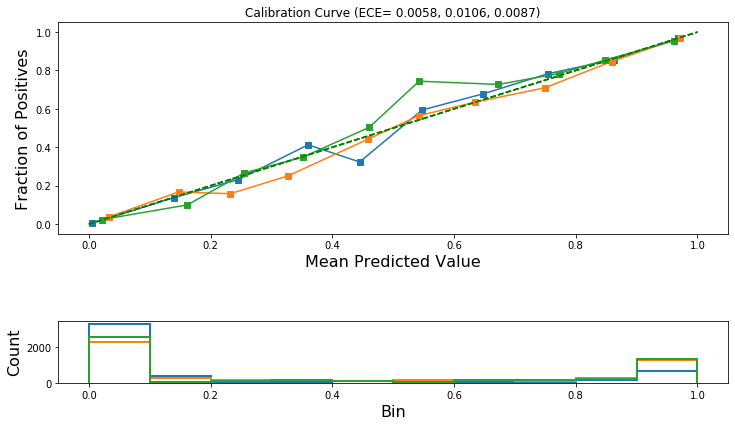

In [56]:
plot_reliability_diagram(
    calibration_data_after_isotonic_scaling,
    test_pred_calibrated_isotonic,
    ece=ece_after_scaling_isotonic,
)

### Compare ECE before and after calibration.

Let's print the ECE for the original model before calibration and for the model after calibration using Temperature Scaling and Isotonic Regression.

If model calibration is successful, then either one or both of the calibrated models should have reduced ECE across all or most of the classes.

In [57]:
cal_error = ",".join(format(e, " 0.4f") for e in ece)
print("ECE before calibration:         {}".format(cal_error))
cal_error = ",".join(format(e, " 0.4f") for e in ece_after_scaling_temperature)
print("ECE after Temperature Scaling:  {}".format(cal_error))
cal_error = ",".join(format(e, " 0.4f") for e in ece_after_scaling_isotonic)
print("ECE after Isotonic Calibration: {}".format(cal_error))

ECE before calibration:          0.0127, 0.0221, 0.0183
ECE after Temperature Scaling:   0.0076, 0.0088, 0.0115
ECE after Isotonic Calibration:  0.0058, 0.0106, 0.0087


### Recalculate classifier accuracy before and after calibration

In [58]:
y_pred = np.argmax(test_pred, axis=1)
y_pred_calibrated_temperature = np.argmax(test_predictions_calibrated_temperature, axis=1)
y_pred_calibrated_isotonic = np.argmax(test_pred_calibrated_isotonic, axis=1)

In [59]:
print(
    "Accuracy before calibration:         {:.2f}".format(
        accuracy_score(y_pred=y_pred, y_true=np.argmax(test_targets, axis=1))
    )
)
print(
    "Accuracy after Temperature Scaling:  {:.2f}".format(
        accuracy_score(
            y_pred=y_pred_calibrated_temperature, y_true=np.argmax(test_targets, axis=1)
        )
    )
)
print(
    "Accuracy after Isotonic Calibration: {:.2f}".format(
        accuracy_score(
            y_pred=y_pred_calibrated_isotonic, y_true=np.argmax(test_targets, axis=1)
        )
    )
)

Accurace before calibration:         0.89
Accurace after Temperature Scaling:  0.89
Accurace after Isotonic Calibration: 0.89


## Conclusion

This notebook demonstrated how to use temperature scaling and isotonic regression to calibrate the output probabilities of a GraphSAGE model used for multi-class node attribute inference.

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/calibration/calibration-node-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/calibration/calibration-node-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>